## Accuracy Linear FOM

Environment

In [1]:
import sys
sys.path.append("/home/zanardi/Codes/ML/RONEK/ronek/")

from ronek import env
env.set(
  device="cpu",
  device_idx=0,
  nb_threads=8,
  floatx="float64"
)

Import libraries

In [2]:
import json
import numpy as np
import scipy as sp

import dill as pickle
from ronek import utils
from ronek.systems import TAFASystem
from silx.io.dictdump import h5todict

Define inputs
> Equilibrium parameters

In [3]:
T = 1e4
rho = 1e-3

> Paths

In [4]:
path_to_dtb = "/home/zanardi/Codes/ML/RONEK/run_03/VC_O3_O4/database/"
path_to_data = "/home/zanardi/Codes/ML/RONEK/run/VC_O3_O4/test/data/"

Initialize isothermal master equation model

In [5]:
system = TAFASystem(
  T=T,
  rates=path_to_dtb + "/kinetics.hdf5",
  species={
    k: path_to_dtb + f"/species/{k}.json" for k in ("atom", "molecule")
  },
  use_einsum=False,
  use_factorial=True
)

In [11]:
data = utils.load_case(path=path_to_data, index=50)
n0 = data["n0"]
t = data["t"]
n = data["n"]
data["mu"]

array([6.22797322e+03, 3.58555138e-01, 1.23459324e-02])

In [12]:
nl = system.solve_lin_fom(t, n0)

In [13]:
import matplotlib.pyplot as plt

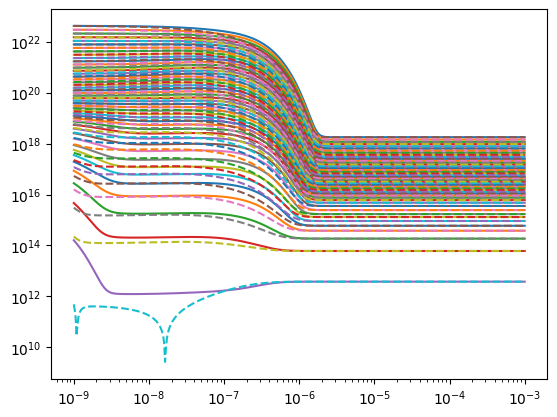

In [14]:
plt.loglog(t, np.abs(n[1].T))
plt.loglog(t, np.abs(nl[1].T), "--")
plt.show()

In [15]:
stop

NameError: name 'stop' is not defined

In [5]:
data = utils.load_case(path=path_to_data, index=0)

In [ ]:
data["n"][1].shape

In [ ]:
def solve_lin_fom(t, n0):
  # Linear operator
  rho = system.mix.get_rho(n0)
  n_eq = system.mix.compute_eq_comp(rho)
  A = system._compute_lin_fom_ops_a_full(n_eq[0], by_mass=False)
  # Eigendecomposition
  l, v = sp.linalg.eig(A)
  vinv = sp.linalg.inv(v)
  # Solution
  n0 -= n_eq
  n = [n_eq + v @ (np.exp(l*ti) * (vinv @ n0)) for ti in t]
  return np.vstack(n).T

In [ ]:

sol = jl.Parallel(inputs["data"]["nb_workers"])(
  jl.delayed(system.compute_rom_sol)(
    path=inputs["data"]["path"],
    index=i,
    filename=None,
    eval_err=inputs["eval_err"]
  ) for i in iterable
)

In [ ]:

  def compute_err_parallel():
    iterable = tqdm(
      iterable=range(inputs["data"]["nb_samples"]),
      ncols=80,
      desc="  Cases",
      file=sys.stdout
    )
    nb_workers = inputs["data"]["nb_workers"]
    if (nb_workers > 1):
      sol = jl.Parallel(inputs["data"]["nb_workers"])(
        jl.delayed(system.compute_rom_sol)(
          path=inputs["data"]["path"],
          index=i,
          filename=None,
          eval_err=inputs["eval_err"]
        ) for i in iterable
      )
    else:
      sol = [
        system.compute_rom_sol(
          path=inputs["data"]["path"],
          index=i,
          filename=None,
          eval_err=inputs["eval_err"]
        ) for i in iterable
      ]
    err, runtime = list(zip(*sol))
    if (inputs["eval_err"] == "mom"):
      return np.stack(err, axis=0), runtime
    else:
      return np.vstack(err), runtime

Initialize isothermal master equation model

In [5]:
system = TAFASystem(
  T=T,
  rates=path_to_dtb + "/kinetics.hdf5",
  species={
    k: path_to_dtb + f"/species/{k}.json" for k in ("atom", "molecule")
  },
  use_einsum=False,
  use_factorial=True
)

Eigedeomposion of the linear operator

In [6]:
A = {}

> FOM

In [7]:
n_eq = system.mix.compute_eq_comp(rho)
A["FOM"] = system._compute_lin_fom_ops_a_full(n_eq[0], by_mass=False)

> ROM

In [8]:
bases = utils.map_nested_dict(path_to_bases, h5todict)

In [9]:
for (r, m) in rom_dims.items():
  # Set basis
  phi = bases[m]["phi"][:,:r]
  psi = bases[m]["psi"][:,:r]
  system._set_basis(phi, psi)
  # Compute ROM linear operator
  A[f"ROM-{r+1}"] = system._compute_lin_fom_ops_a_full(
    n_a_eq=n_eq[0],
    phi=system.phi,
    psi=system.psi,
    by_mass=False
  )

> Compute fastest timescale

In [10]:
def get_timescale(A):
  l = sp.linalg.eigvals(A)
  lmin = np.abs(l.real.min())
  return 1.0/lmin

In [11]:
timescales = utils.map_nested_dict(A, get_timescale)
with open("./timescales.json", "w") as file:
  json.dump(timescales, file, indent=2)